F1 Predict Project

## Data import

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

%matplotlib inline

In [2]:
# Racing stats

race = pd.read_csv('Race_base.csv', names = ['pos', 'no', 'driver', 'team', 'laps', 
                                             'time', 'points', 'race_no', 'season', 'track'], skiprows = [0])
race.drop(['no', 'points'], axis = 1, inplace = True)
race.head()

,pos,driver,team,laps,time,race_no,season,track
0,1,Sebastian Vettel,FERRARI,57,1:24:11.672,1,2017,Albert Park
1,2,Lewis Hamilton,MERCEDES,57,+9.975s,1,2017,Albert Park
2,3,Valtteri Bottas,MERCEDES,57,+11.250s,1,2017,Albert Park
3,4,Kimi Räikkönen,FERRARI,57,+22.393s,1,2017,Albert Park
4,5,Max Verstappen,RED BULL RACING TAG HEUER,57,+28.827s,1,2017,Albert Park


In [43]:
# Qualification results dataset

qual = pd.read_csv('Quali_base.csv', names = ['pos', 'no', 'driver', 'team', 'q1', 'q2', 'q3', 'laps', 'race_no', 'season', 'track'],
                   skiprows = [0])
qual.drop('no', axis = 1, inplace = True)
qual.head()

,pos,driver,team,q1,q2,q3,laps,race_no,season,track
0,1,Lewis Hamilton,MERCEDES,1:24.191,1:23.251,1:22.188,14,1,2017,Albert Park
1,2,Sebastian Vettel,FERRARI,1:25.210,1:23.401,1:22.456,17,1,2017,Albert Park
2,3,Valtteri Bottas,MERCEDES,1:24.514,1:23.215,1:22.481,13,1,2017,Albert Park
3,4,Kimi Räikkönen,FERRARI,1:24.352,1:23.376,1:23.033,19,1,2017,Albert Park
4,5,Max Verstappen,RED BULL RACING TAG HEUER,1:24.482,1:24.092,1:23.485,18,1,2017,Albert Park


In [4]:
# Practice sessions results dataset

prac = pd.read_csv('Practice_base.csv', names = ['pos', 'no', 'driver', 'team', 'time', 'gap', 'laps', 'session', 'race_no', 'season', 'track'],
                  skiprows = [0])
prac.drop('no', axis = 1, inplace = True)
prac.head()

,pos,driver,team,time,gap,laps,session,race_no,season,track
0,1,Lewis Hamilton,MERCEDES,1:24.220,NaN,22.0,P1,1,2017,Albert Park
1,2,Valtteri Bottas,MERCEDES,1:24.803,+0.583s,25.0,P1,1,2017,Albert Park
2,3,Daniel Ricciardo,RED BULL RACING TAG HEUER,1:24.886,+0.666s,19.0,P1,1,2017,Albert Park
3,4,Max Verstappen,RED BULL RACING TAG HEUER,1:25.246,+1.026s,19.0,P1,1,2017,Albert Park
4,5,Kimi Räikkönen,FERRARI,1:25.372,+1.152s,16.0,P1,1,2017,Albert Park


## Race feature engineering

In [95]:
race['team'].value_counts()

MERCEDES                     138
SAUBER FERRARI               138
FERRARI                      138
FORCE INDIA MERCEDES         138
WILLIAMS MERCEDES            137
MCLAREN HONDA                120
HAAS FERRARI                 100
RENAULT                      100
RED BULL RACING TAG HEUER    100
TORO ROSSO FERRARI            42
MRT MERCEDES                  42
TORO ROSSO                    40
RED BULL RACING RENAULT       38
STR RENAULT                   38
LOTUS MERCEDES                38
MARUSSIA FERRARI              35
MCLAREN RENAULT               18
SCUDERIA TORO ROSSO HONDA     18
Name: team, dtype: int64

In [5]:
# Separate engine supplier
# Setting Red Bull's Tag Heuer in 2018 as Renault (it is)
# Setting Toro Rosso's 2017 "no engine" as Renault (it is)

race['engine'] = '-'
race.loc[race['team'].str.contains('FERRARI'), 'engine'] = 'Ferrari'
race.loc[race['team'].str.contains('MERCEDES'), 'engine'] = 'Mercedes'
race.loc[race['team'].str.contains('|'.join(['RENAULT', 'TAG'])), 'engine'] = 'Renault'
race.loc[race['team'].str.contains('HONDA'), 'engine'] = 'Honda'
race.loc[race['team'] == 'TORO ROSSO', 'engine'] = 'Renault'

race['engine'].value_counts()

Mercedes    493
Ferrari     453
Renault     334
Honda       138
Name: engine, dtype: int64

In [6]:
# Rename teams to unified pattern
# Proceeding nicely, putting manufacturer's team in the end, as all teams contain engine in the name

race.loc[race['team'].str.contains('SAUBER'), 'team'] = 'Sauber'
race.loc[race['team'].str.contains('FORCE'), 'team'] = 'Force India'
race.loc[race['team'].str.contains('TORO'), 'team'] = 'Toro Rosso'
race.loc[race['team'].str.contains('MCLAREN'), 'team'] = 'Mclaren'
race.loc[race['team'].str.contains('HAAS'), 'team'] = 'Haas'
race.loc[race['team'].str.contains('WILLIAMS'), 'team'] = 'Williams'
race.loc[race['team'].str.contains('STR'), 'team'] = 'Toro Rosso'
race.loc[race['team'].str.contains('BULL'), 'team'] = 'Red Bull'
race.loc[race['team'].str.contains('|'.join(['MARUSSIA', 'MRT'])), 'team'] = 'Marussia'
race.loc[race['team'].str.contains('LOTUS'), 'team'] = 'Lotus'
race.loc[race['team'].str.contains('FERRARI'), 'team'] = 'Ferrari'
race.loc[race['team'].str.contains('RENAULT'), 'team'] = 'Renault'
race.loc[race['team'].str.contains('MERCEDES'), 'team'] = 'Mercedes'

In [98]:
race['team'].value_counts()

Mercedes       138
Ferrari        138
Toro Rosso     138
Force India    138
Mclaren        138
Red Bull       138
Sauber         138
Williams       137
Renault        100
Haas           100
Marussia        77
Lotus           38
Name: team, dtype: int64

In [7]:
# Calculating distance passed before withdrawal
# Those finished the race in several laps behind the winner are considered passed 100% distance

race['distance'] = 0
races = [x for x in range(1, 22)]
seasons = [2015, 2016, 2017, 2018]

for s in seasons:
    for r in races:
        race.loc[(race['season'] == s) & (race['race_no'] == r) & (race['time'] != 'DNF'), 'distance'] = 1
        laps = race.loc[(race['season'] == s) & (race['race_no'] == r) & (race['time'] == 'DNF'), 'laps'].values
        overall_laps = race.loc[(race['season'] == s) & (race['race_no'] == r) & (race['pos'] == 1), 'laps'].values
        race.loc[(race['season'] == s) & (race['race_no'] == r) & (race['time'] == 'DNF'), 'distance'] = laps / overall_laps

In [100]:
race.head(20)

,pos,driver,team,laps,time,race_no,season,track,engine,distance
0,1,Sebastian Vettel,Ferrari,57,1:24:11.672,1,2017,Albert Park,Ferrari,1.000000
1,2,Lewis Hamilton,Mercedes,57,+9.975s,1,2017,Albert Park,Mercedes,1.000000
2,3,Valtteri Bottas,Mercedes,57,+11.250s,1,2017,Albert Park,Mercedes,1.000000
3,4,Kimi Räikkönen,Ferrari,57,+22.393s,1,2017,Albert Park,Ferrari,1.000000
4,5,Max Verstappen,Red Bull,57,+28.827s,1,2017,Albert Park,Renault,1.000000
5,6,Felipe Massa,Williams,57,+83.386s,1,2017,Albert Park,Mercedes,1.000000
6,7,Sergio Perez,Force India,56,+1 lap,1,2017,Albert Park,Mercedes,1.000000
7,8,Carlos Sainz,Toro Rosso,56,+1 lap,1,2017,Albert Park,Renault,1.000000
8,9,Daniil Kvyat,Toro Rosso,56,+1 lap,1,2017,Albert Park,Renault,1.000000
9,10,Esteban Ocon,Force India,56,+1 lap,1,2017,Albert Park,Mercedes,1.000000


## Qualification feature engineering

In [44]:
# Adding features for 2nd and 3rd quali segments if driver made through

qual['is_q2'] = 0
qual['is_q3'] = 0
qual.loc[~qual['q2'].isna(), 'is_q2'] = 1
qual.loc[~qual['q3'].isna(), 'is_q3'] = 1

In [45]:
# Calculating quali best time for driver

qual.loc[qual['q1'].isna(), 'q1'] = '10:00.000'
qual.drop(qual[qual['q1'] == '10:00.000'].index, inplace = True)
qual.loc[qual['q2'].isna(), 'q2'] = '10:00.000'
qual.loc[qual['q3'].isna(), 'q3'] = '10:00.000'

# Calculating all quali times in seconds
quali_times = []
for q_segment in ['q1', 'q2', 'q3']:
    qual.loc[qual[q_segment].str.contains('|'.join(['DNF', 'DNS'])), q_segment] = '10:00.000'
    q_res = [datetime.strptime(x, '%M:%S.%f') for x in qual[q_segment].values]
    q_sec = [a.minute * 60 + a.second + a.microsecond / 1000000 for a in q_res]
    new_seg = q_segment + '_sec'
    quali_times.append(q_sec)
    qual[new_seg] = q_sec
    
# Choosing the fastest time for a drive in all segments
times_per_driver = [min(a, b, c) for a, b, c in zip(quali_times[0], quali_times[1], quali_times[2])]
qual['best_time'] = times_per_driver

In [81]:
# Best time leader gap (share, here and below)

# !!! CLEAN THE MEMORY AFTER ARRANGING TO FUNCTIONS

races = [x for x in range(1, 22)]
seasons = [2015, 2016, 2017, 2018]

qual['leader_gap'] = 0
for s in seasons:
    for r in races:
        leader = qual[(qual['pos'] == 1) & (qual['race_no'] == r) & (qual['season'] == s)]['best_time'].values
        gaps = [(x - leader) / leader for x in qual[(qual['race_no'] == r) & (qual['season'] == s)]['best_time'].values]
        qual.loc[(qual['race_no'] == r) & (qual['season'] == s), 'leader_gap'] = gaps

# Best time front gap

# !! TRY TO CHECK GAP BEHIND

qual['front_gap'] = 0
qual['best_time_order'] = 0
for s in seasons:
    for r in races:
        real_order = pd.DataFrame({'best_time': qual[(qual['race_no'] == r) & (qual['season'] == s)]['best_time'].values, 
                                   'pos': qual[(qual['race_no'] == r) & (qual['season'] == s)]['pos'].values})
        real_order = real_order.sort_values(by = 'best_time').reset_index(drop = True)
        real_order['best_time_pos'] = [x + 1 for x in real_order.index.tolist()]
        
        time_front = real_order['best_time'].values
        gaps = [0]
        for i in range(1, real_order.shape[0]):
            gaps.append((time_front[i] - time_front[i - 1]) / time_front[i - 1])
        real_order['front_gap'] = gaps
        
        old_order = real_order.sort_values(by = 'pos').reset_index()
        front_gaps = old_order['front_gap'].values
        best_time_order = [x + 1 for x in old_order['index'].values]
        
        qual.loc[(qual['race_no'] == r) & (qual['season'] == s), 'front_gap'] = front_gaps
        qual.loc[(qual['race_no'] == r) & (qual['season'] == s), 'best_time_order'] = best_time_order

# Best time median ahead and behind gap

qual['median_ahead'] = 0
qual['median_behind'] = 0
for s in seasons:
    for r in races:
        race_df = qual.loc[(qual['race_no'] == r) & (qual['season'] == s), ['best_time', 'best_time_order', 'front_gap', 'pos']]
        race_df = race_df.sort_values(by = ['best_time']).reset_index(drop = True)
        
        print(s, r)
        
        # Medians ahead
        
        medians = [0, race_df.iloc[1]['front_gap'] / 2]
        for i in range(2, race_df.shape[0]):
            times = race_df.iloc[:i]['best_time'].values
            medians.append(race_df.iloc[i]['best_time'] - np.median(times))
            
        race_df['medians_ahead'] = medians    
            
        #  Medians behind
        
        medians = []
        
        for i in range(race_df.shape[0] - 2):
            times = race_df.iloc[i + 1:]['best_time'].values
            medians.append(race_df.iloc[i]['best_time'] - np.median(times))
            
        medians.append((race_df.iloc[race_df.shape[0] - 2]['best_time'] - race_df.iloc[race_df.shape[0] - 1]['best_time']) / 2)
        medians.append(0)
        
        race_df['medians_behind'] = medians
        
        old_order = race_df.sort_values(by = 'pos').reset_index(drop = True)
        median_ahead = old_order['medians_ahead'].values
        median_behind = old_order['medians_behind'].values
        qual.loc[(qual['race_no'] == r) & (qual['season'] == s), 'median_ahead'] = median_ahead
        qual.loc[(qual['race_no'] == r) & (qual['season'] == s), 'median_behind'] = median_behind

2015 1
2015 2
2015 3
2015 4
2015 5
2015 6
2015 7
2015 8
2015 9
2015 10
2015 11
2015 12
2015 13
2015 14
2015 15
2015 16
2015 17
2015 18
2015 19
2015 20


IndexError: single positional indexer is out-of-bounds

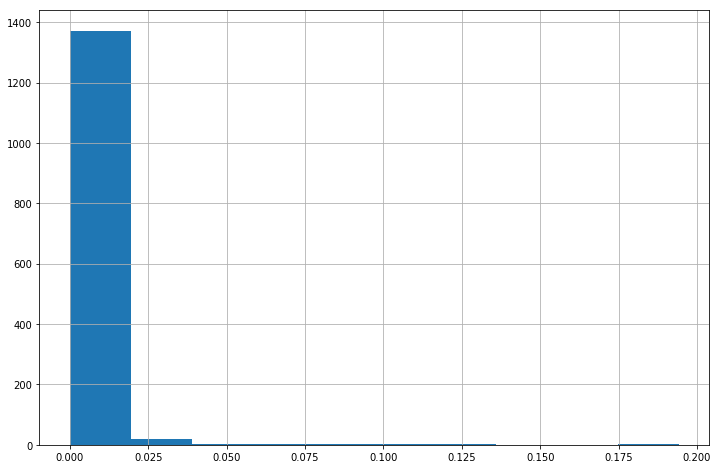

In [76]:
fig = plt.figure(figsize = (12, 8))

qual[qual['front_gap'] < 1]['front_gap'].hist()

plt.show()

In [79]:
qual[(qual['front_gap'] < 1) & (qual['front_gap'] > 0.1)]

,pos,driver,team,q1,q2,q3,laps,race_no,season,track,...,is_q3,q1_sec,q2_sec,q3_sec,best_time,leader_gap,front_gap,best_time_order,median_ahead,median_behind
195,16,Lance Stroll,WILLIAMS MERCEDES,1:42.573,10:00.000,10:00.000,11,10,2017,Silverstone,...,0,102.573,600.0,600.0,102.573,0.184446,0.121237,16,0.0,0.0
478,19,Brendon Hartley,SCUDERIA TORO ROSSO HONDA,1:57.354,10:00.000,10:00.000,5,4,2018,Baku City Circuit,...,0,117.354,600.0,600.0,117.354,0.156220,0.111928,19,0.0,0.0
796,17,Jolyon Palmer,RENAULT,1:43.965,10:00.000,10:00.000,9,11,2016,Hungaroring,...,0,103.965,600.0,600.0,103.965,0.300131,0.194135,17,0.0,0.0


In [89]:
qual[qual['season'] == 2018]['race_no'].unique()

array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [ ]:
races_list = [(20)]

## Practice feature engineering